<a href="https://colab.research.google.com/github/yohanesnuwara/geostatistics/blob/main/project_notebooks/gullfaks_poroperm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 !git clone https://github.com/yohanesnuwara/geostatistics
!git clone https://github.com/yohanesnuwara/formation-evaluation

Cloning into 'geostatistics'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 283 (delta 65), reused 0 (delta 0), pack-reused 144
Receiving objects: 100% (283/283), 91.26 MiB | 11.90 MiB/s, done.
Resolving deltas: 100% (124/124), done.
Checking out files: 100% (57/57), done.
Cloning into 'formation-evaluation'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 141 (delta 64), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (141/141), 8.06 MiB | 3.12 MiB/s, done.
Resolving deltas: 100% (64/64), done.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append("/content/formation-evaluation")
from merge_data_interpolation import merge_data_interpolation
from regrid import regrid

## Well top data

In [ ]:
# Load well top data
colnames = ["UTM X", "UTM Y", "TVD", "Top Name", "Well Name"]
welltop = pd.read_csv("/content/geostatistics/data/gullfaks/welltops.txt", sep=" ", 
                   header=17, usecols=[0,1,2,5,6], names=colnames)

# Invert -TVD to +TVD
welltop["TVD"] = welltop["TVD"] * -1

welltop.tail(10)

,UTM X,UTM Y,TVD,Top Name,Well Name
87,457215.45,6782674.59,1766.94,Tarbert2,A10
88,454933.23,6786210.63,2085.96,Tarbert2,C4
89,457753.72,6787108.51,1899.08,Tarbert2,B8
90,458428.93,6785838.51,1816.94,Tarbert2,B2
91,451497.31,6781788.24,2111.21,Tarbert2,C6
92,452267.75,6784852.47,2046.28,Tarbert2,C7
93,453536.01,6783001.80,1979.10,Tarbert2,C5
94,456717.47,6785548.40,1858.92,Tarbert2,B9
95,457920.31,6784738.68,1783.84,Tarbert2,B4
96,454990.71,6786210.63,2126.46,Tarbert1,C4


Produce list of horizon depths per well.

In [ ]:
welltop_creta = welltop[welltop["Top Name"]=="Base Cretaceous"].sort_values("Well Name").reset_index(drop=True)
welltop_tarb = welltop[welltop["Top Name"]=="Top Tarbert"].sort_values("Well Name").reset_index(drop=True)
welltop_etive = welltop[welltop["Top Name"]=="Top Etive"].sort_values("Well Name").reset_index(drop=True)
welltop_ness = welltop[welltop["Top Name"]=="Top Ness"].sort_values("Well Name").reset_index(drop=True)

# Because well B4 doesn't have Base Cretaceous, B4 is removed from analysis
welltop_tarb = welltop_tarb[~(welltop_tarb["Well Name"]=="B4")]
welltop_etive = welltop_etive[~(welltop_etive["Well Name"]=="B4")]
welltop_ness = welltop_ness[~(welltop_ness["Well Name"]=="B4")]

z = []
for i in [welltop_creta, welltop_tarb, welltop_etive, welltop_ness]:
  _ = i["TVD"].values
  z.append(_)

# List of horizon depths per well
z_creta, z_tarb, z_etive, z_ness = z

z_creta

array([1766.94, 1855.49, 1805.45, 1812.87, 1886.76, 1836.19, 1996.92,
       1977.81, 1989.68, 1965.23, 1916.14, 2000.51, 2000.56])

## Well log data

In [ ]:
path = "/content/geostatistics/data/gullfaks/Gullfaks_well_poroperm.csv"

df = pd.read_csv(path)

df

,depth,poro,perm,well
0,1499.8790,-999.250000,-999.25000,A10
1,1500.1290,-999.250000,-999.25000,A10
2,1500.6290,-999.250000,-999.25000,A10
3,1501.1290,0.270646,-999.25000,A10
4,1501.6290,0.267428,124.57990,A10
...,...,...,...,...
20193,2571.5419,0.157732,331.12872,C7
20194,2572.0419,0.146786,287.46310,C7
20195,2572.5419,0.126561,180.20058,C7
20196,2573.0419,-999.250000,-999.25000,C7


## Trajectory data

In [ ]:
path = "/content/geostatistics/data/gullfaks/Gullfaks_well_trajectory.csv"

traj = pd.read_csv(path)

traj.head()

,x,y,tvd,md,well
0,456979.0637,6782712.412,1499.878992,1499.878992,A10
1,456979.1646,6782712.394,1499.991677,1500.031292,A10
2,456979.2657,6782712.377,1500.104433,1500.183692,A10
3,456979.3666,6782712.359,1500.217110,1500.335992,A10
4,456979.4676,6782712.342,1500.329784,1500.488292,A10


TVD interpolation. Depth in well log is still in MD. Therefore, TVD is generated by interpolating MD-TVD data from the trajectory.

In [ ]:
wellnames = list(df.well.unique())

appended_data = []
for i in range(len(wellnames)):
  # Well log dataframes per individual well
  df_ = df[df.well==wellnames[i]]

  # Trajectory dataframes per individual well
  traj_ = traj[traj.well==wellnames[i]]

  # Interpolate MD-TVD from traj to produce TVD in well log
  df_data, df_new = traj_, df_
  xdata, xnew = "md", "depth"
  ydata = ["tvd"]
  df_ = merge_data_interpolation(df_data, df_new, xdata, ydata, xnew, kind="cubic")

  # Append dataframe
  appended_data.append(df_)

# Concatenate all dataframes
df_new = pd.concat(appended_data)

# Convert -999.25 into NaNs
df_new = df_new[(df_new["poro"]>=-999) & (df_new["perm"]>=-999)]

# Remove NaNs
df_new = df_new.dropna()

df_new

,depth,poro,perm,well,tvd
4,1501.6290,0.267428,124.57990,A10,1501.173566
5,1502.1290,0.256076,125.33458,A10,1501.543344
6,1502.6290,0.242126,117.12110,A10,1501.913075
7,1503.1290,0.238589,109.64679,A10,1502.282761
8,1503.6290,0.238377,106.01107,A10,1502.652403
...,...,...,...,...,...
20191,2570.5419,0.134343,404.45474,C7,2377.053250
20192,2571.0419,0.130360,351.35257,C7,2377.261790
20193,2571.5419,0.157732,331.12872,C7,2377.470331
20194,2572.0419,0.146786,287.46310,C7,2377.678871


Display the permeability log with Fm tops. Remove well B4 because it doesn't have marker information of Base Cretaceous.

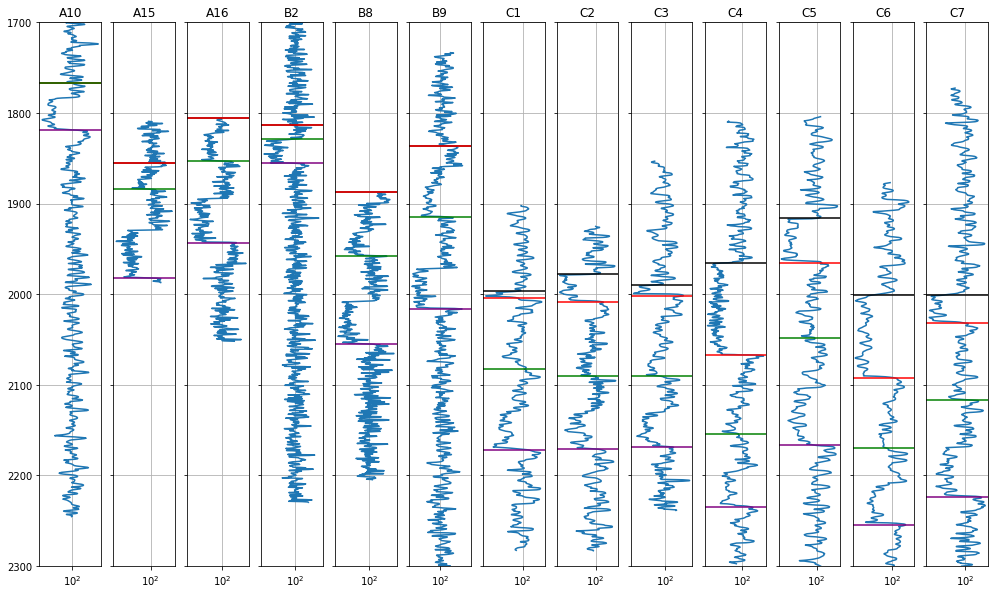

In [ ]:
wellnames = list(df_new.well.unique())
wellnames.remove("B4") # Remove well B4

plt.figure(figsize=(17,10))
for i in range(len(wellnames)):
  df_ = df_new[df_new.well==wellnames[i]]
  depth, perm, poro = df_.tvd.values, df_.perm.values, df_.poro.values
  
  # Plot log permeability (klog)
  plt.subplot(1,len(wellnames),i+1)
  plt.semilogx(perm, depth)
  # plt.step(np.log10(perm), depth)
  # plt.xlim(0,0.3)

  # Plot formation tops
  plt.axhline(z_creta[i], color="black")
  plt.axhline(z_tarb[i], color="red")
  plt.axhline(z_ness[i], color="green")  
  plt.axhline(z_etive[i], color="purple")

  plt.ylim(2300, 1700)
  plt.title(wellnames[i])
  plt.grid(True, which="both")

  if i>0:
    # Make y-axis invisible
    plt.gca().set_yticklabels([])

# plt.tight_layout()
plt.show()

Observation:

* Base Cretaceous (black) & Top Tarbert (red) overlap in well A10, A15, A16, B2, B8, B9

* Base Cretaceous (black), Top Tarbert (red), and Top Ness (green) overlap in well A10

Well A10 can then be excluded from analysis.

So, Tarbert Fm and Ness Fm has the most complete wells 

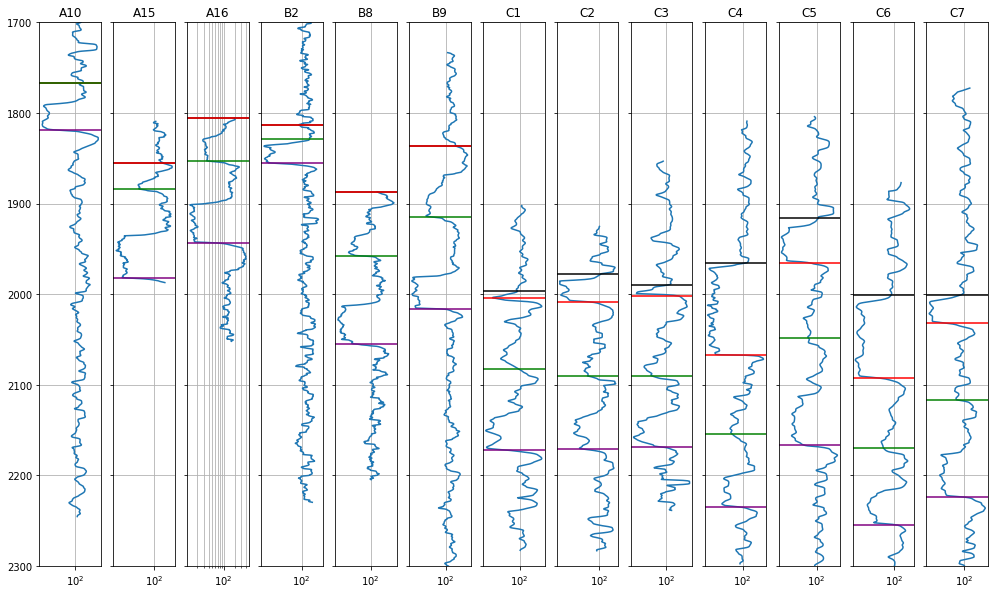

In [ ]:
# Rolling average
df_new['perm_averaged'] = df_new.perm.rolling(window=20).mean()

# Plot averaged log
wellnames = list(df_new.well.unique())
wellnames.remove("B4") # Remove well B4

plt.figure(figsize=(17,10))
for i in range(len(wellnames)):
  df_ = df_new[df_new.well==wellnames[i]]
  depth, perm, poro = df_.tvd.values, df_.perm_averaged.values, df_.poro.values
  
  # Plot log permeability (klog)
  plt.subplot(1,len(wellnames),i+1)
  plt.semilogx(perm, depth)
  # plt.step(np.log10(perm), depth)
  # plt.xlim(0,0.3)

  # Plot formation tops
  plt.axhline(z_creta[i], color="black")
  plt.axhline(z_tarb[i], color="red")
  plt.axhline(z_ness[i], color="green")  
  plt.axhline(z_etive[i], color="purple")

  plt.ylim(2300, 1700)
  plt.title(wellnames[i])
  plt.grid(True, which="both")

  if i>0:
    # Make y-axis invisible
    plt.gca().set_yticklabels([])

# plt.tight_layout()
plt.show()

In [ ]:
def regrid(df, column_depth, column_feature, depth_regrid):
  """
  Regrid log data to coarsen or to produce blocky log
  """
  import numpy as np
  import pandas as pd

  # Make endpoints (lower and upper depth)
  endpoint0, endpoint1 = np.array(depth_regrid[:-1]), np.array(depth_regrid[1:])
  midpoint = 0.5 * (endpoint0 + endpoint1)

  x_avg = []
  for i in range(len(endpoint0)):
    # Select dataframe at depths between endpoints
    df_ = df[(df[column_depth]>=endpoint0[i]) & (df[column_depth]<=endpoint1[i])]
    
    # Take average
    x = df_[column_feature].values
    x_avg_ = np.mean(x)
    x_avg.append(x_avg_)
  
  # Make new dataframe
  df_regrid = pd.DataFrame({column_depth+"_regrid": midpoint, column_feature+"_regrid": x_avg})

  return df_regrid

Depth averaging plot (block log plot)

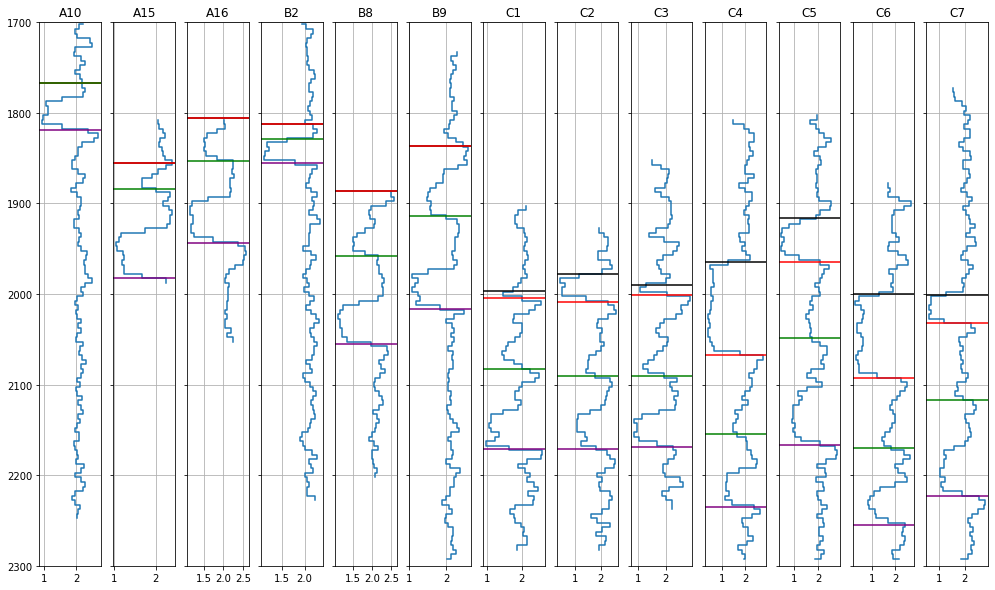

In [ ]:
import warnings 
warnings.filterwarnings("ignore", category=RuntimeWarning)

## INPUT
min_tvd, max_tvd = 1700, 2300 # Minimum and maximum depth
no_of_intervals = 20 # Each Fm will be divided into 50 equal intervals

## PLOTTING
wellnames = list(df_new.well.unique())
wellnames.remove("B4") # Remove well B4

plt.figure(figsize=(17,10))
for i in range(len(wellnames)):
  df_ = df_new[df_new.well==wellnames[i]]

  # Re-gridding

  ## Divide each formation into equal thicknesses
  # min_creta, max_creta = min_tvd, z_tarb[i]
  # min_tarb, max_tarb = z_tarb[i], z_ness[i]
  # min_ness, max_ness = z_ness[i], z_etive[i]
  # min_etive, max_etive = z_etive[i], max_tvd  

  # tops = [min_creta, min_tarb, min_ness, min_etive]
  # bott = [max_creta, max_tarb, max_ness, max_etive]

  # tvd_grid = []
  # for j in range(len(tops)):
  #   grid = np.linspace(tops[j], bott[j], no_of_intervals)
  #   tvd_grid.append(grid)

  # tvd_grid = [item for sublist in tvd_grid for item in sublist]
  tvd_grid = np.arange(1700, 2300, 5)

  df_regrid = regrid(df_, "tvd", "perm", tvd_grid)
  depth, perm = df_regrid.tvd_regrid, df_regrid.perm_regrid
  
  # Plot log permeability (klog)
  plt.subplot(1,len(wellnames),i+1)
  # plt.semilogx(perm, depth)
  plt.step(np.log10(perm), depth, where="mid")
  # plt.xlim(0,0.3)

  # Plot formation tops
  plt.axhline(z_creta[i], color="black")
  plt.axhline(z_tarb[i], color="red")
  plt.axhline(z_ness[i], color="green")  
  plt.axhline(z_etive[i], color="purple")

  plt.ylim(2300, 1700)
  plt.title(wellnames[i])
  plt.grid(True, which="both")

  if i>0:
    # Make y-axis invisible
    plt.gca().set_yticklabels([])

# plt.tight_layout()
plt.show()

## Add amplitude top data

In another notebook "gullfaks_seismic_horizon_extraction", the seismic volume is extracted on Ness horizon. The result is in TXT. Add the output file to visualize here in this notebook.

In [99]:
path = "/content/Ness_extracted_amplitude.txt"

ness = np.loadtxt(path)

ness_x, ness_y, ness_amps = ness[:,0], ness[:,1], ness[:,3]

ness_amps

array([           nan,            nan,            nan, ...,
       -1081.34335282,   411.7365815 , -1128.89464851])

## Histograms and Maps

Tarbert formation porosity histogram

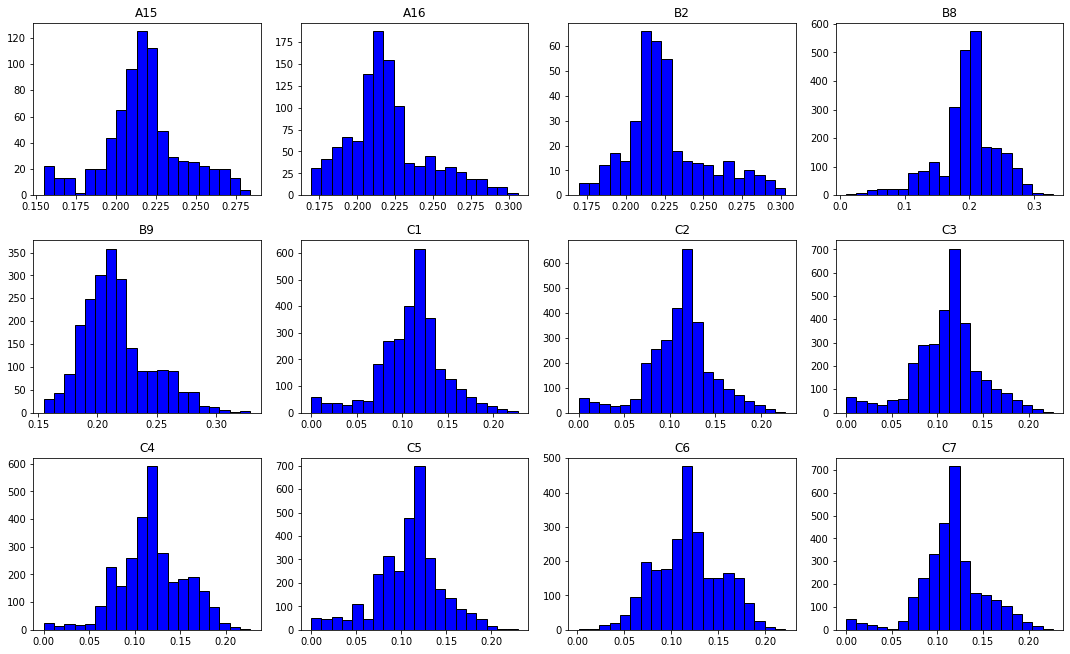

In [ ]:
wellnames = list(df_new.well.unique())
wellnames.remove("B4") # Remove well B4
# wellnames.remove("A10") # Remove well A10

plt.figure(figsize=(15,12))

for i in range(len(wellnames)):
  depth_top_tarb, depth_top_ness = z_tarb[i], z_ness[i]
  
  # Select dataframe of Tarbert Fm
  df_tarb = df_new[(df_new.tvd>=depth_top_tarb) & (df_new.tvd<=depth_top_ness)]
  poro = df_tarb.poro.values
  log_perm = np.log10(perm)

  if i>0:
    # Plot histogram
    plt.subplot(4,4,i)
    plt.hist(poro, bins=20, color="blue", edgecolor="black")
    plt.title(wellnames[i])

plt.tight_layout(1.2)
plt.show()

Tarbert formation permeability histogram

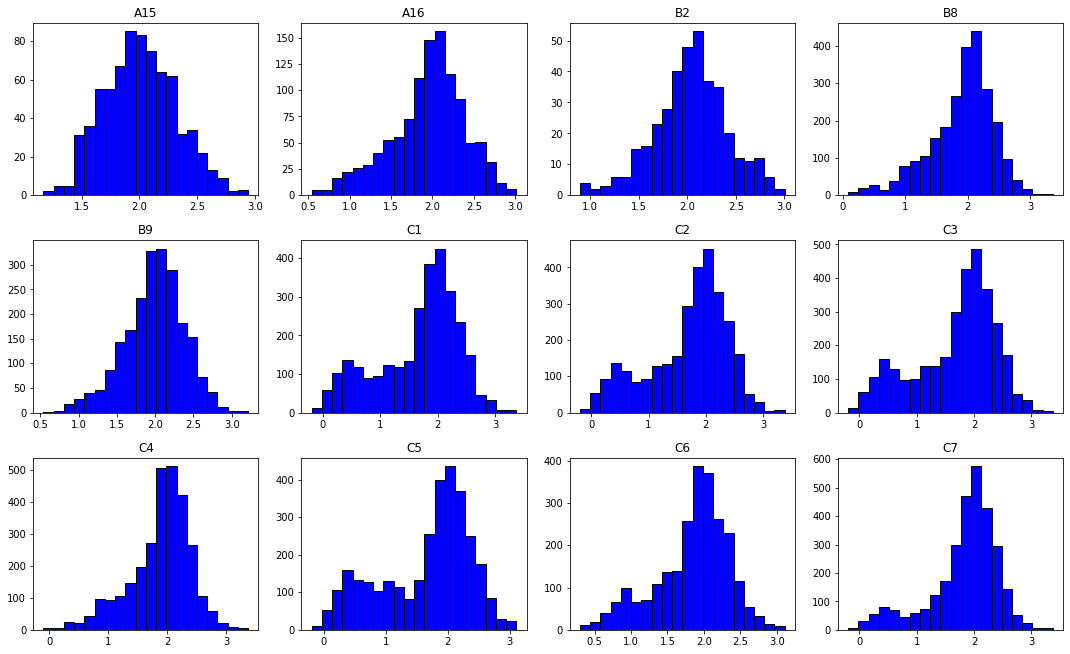

In [ ]:
wellnames = list(df_new.well.unique())
wellnames.remove("B4") # Remove well B4
# wellnames.remove("A10") # Remove well A10

plt.figure(figsize=(15,12))

for i in range(len(wellnames)):
  depth_top_tarb, depth_top_ness = z_tarb[i], z_ness[i]
  
  # Select dataframe of Tarbert Fm
  df_tarb = df_new[(df_new.tvd>=depth_top_tarb) & (df_new.tvd<=depth_top_ness)]
  perm = df_tarb.perm.values
  log_perm = np.log10(perm)

  if i>0:
    # Plot histogram
    plt.subplot(4,4,i)
    plt.hist(log_perm, bins=20, color="blue", edgecolor="black")
    plt.title(wellnames[i])

plt.tight_layout(1.2)
plt.show()

Ness formation permeability

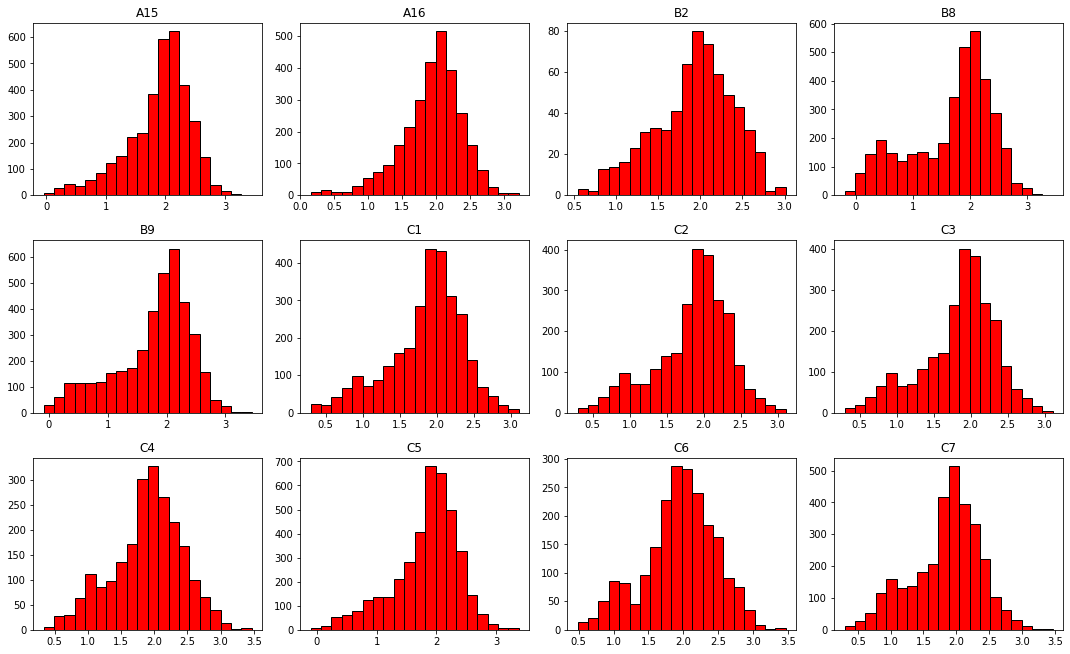

In [ ]:
wellnames = list(df_new.well.unique())
wellnames.remove("B4") # Remove well B4
# wellnames.remove("A10") # Remove well A10

plt.figure(figsize=(15,12))

for i in range(len(wellnames)):
  depth_top_ness, depth_top_etive = z_ness[i], z_etive[i]
  
  # Select dataframe of Tarbert Fm
  df_ness = df_new[(df_new.tvd>=depth_top_ness) & (df_new.tvd<=depth_top_etive)]
  perm = df_ness.perm.values
  log_perm = np.log10(perm)

  if i>0:
    # Plot histogram
    plt.subplot(4,4,i)
    plt.hist(log_perm, bins=20, color="red", edgecolor="black")
    plt.title(wellnames[i])

plt.tight_layout(1.2)
plt.show()

Ness formation porosity map

In [ ]:
percentile25 = lambda x: np.percentile(x, 25)
percentile50 = lambda x: np.percentile(x, 50)
percentile75 = lambda x: np.percentile(x, 75)

Mean poro of well A10: 0.2184
Mean poro of well A15: 0.1754
Mean poro of well A16: 0.2116
Mean poro of well B2: 0.2177
Mean poro of well B8: 0.1096
Mean poro of well B9: 0.1421
Mean poro of well C1: 0.1183
Mean poro of well C2: 0.1183
Mean poro of well C3: 0.1182
Mean poro of well C4: 0.1186
Mean poro of well C5: 0.1167
Mean poro of well C6: 0.1191
Mean poro of well C7: 0.1176


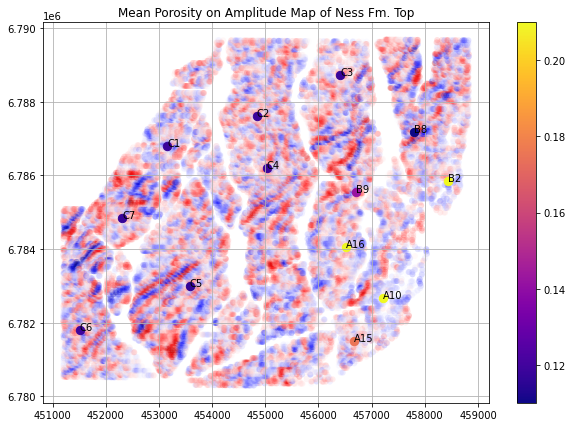

In [107]:
# Statistics function to calculate
f = np.mean

wellnames = list(df_new.well.unique())
wellnames.remove("B4") # Remove well B4
# wellnames.remove("A10") # Remove well A10

plt.figure(figsize=(10,7))

# Add scatter plot of Ness amplitudes
plt.scatter(ness_x, ness_y, c=ness_amps, cmap='seismic', linewidths=0, alpha=0.2)

poro_ness = pd.DataFrame(columns=["well", "x", "y", "avgporo"],
                         index=np.arange(len(wellnames)))

for i in range(len(wellnames)):
  depth_top_ness, depth_top_etive = z_ness[i], z_etive[i]
  
  # Select dataframe of Ness Fm
  df_ness = df_new[(df_new.tvd>=depth_top_ness) & (df_new.tvd<=depth_top_etive)]
  poro = df_ness.poro.values

  # Statistics of poroperm
  poro = f(poro)
  print("Mean poro of well {}: {:.4f}".format(wellnames[i], poro))

  # Get well coordinates on Ness Fm top
  df_ = welltop_ness[welltop_ness["Well Name"]==wellnames[i]]
  x, y = df_["UTM X"].values, df_["UTM Y"].values
  
  plt.scatter(x,y,c=poro,cmap='plasma', vmin=0.11,vmax=0.21, s=70)
  plt.annotate(wellnames[i], (x, y))

  # Record
  poro_ness.well.iloc[i] = wellnames[i]
  poro_ness.x.iloc[i] = x[0]
  poro_ness.y.iloc[i] = y[0]
  poro_ness.avgporo.iloc[i] = poro

plt.title("Mean Porosity on Amplitude Map of Ness Fm. Top")
plt.grid()
plt.colorbar()
plt.show()

In [ ]:
poro_ness

,well,x,y,avgporo
0,A10,457215,6.78267e+06,0.218431
1,A15,456661,6.7815e+06,0.175425
2,A16,456516,6.78406e+06,0.211644
3,B2,458443,6.78584e+06,0.217715
4,B8,457789,6.78719e+06,0.10956
5,B9,456714,6.78554e+06,0.14207
6,C1,453156,6.78679e+06,0.118299
7,C2,454840,6.78761e+06,0.118321
8,C3,456410,6.78872e+06,0.11819
9,C4,455024,6.78621e+06,0.118624


In [ ]:
np.savetxt("Top Ness Porosity.txt", poro_ness.values, delimiter=" ", fmt="%s")

## Make depth map from well tops

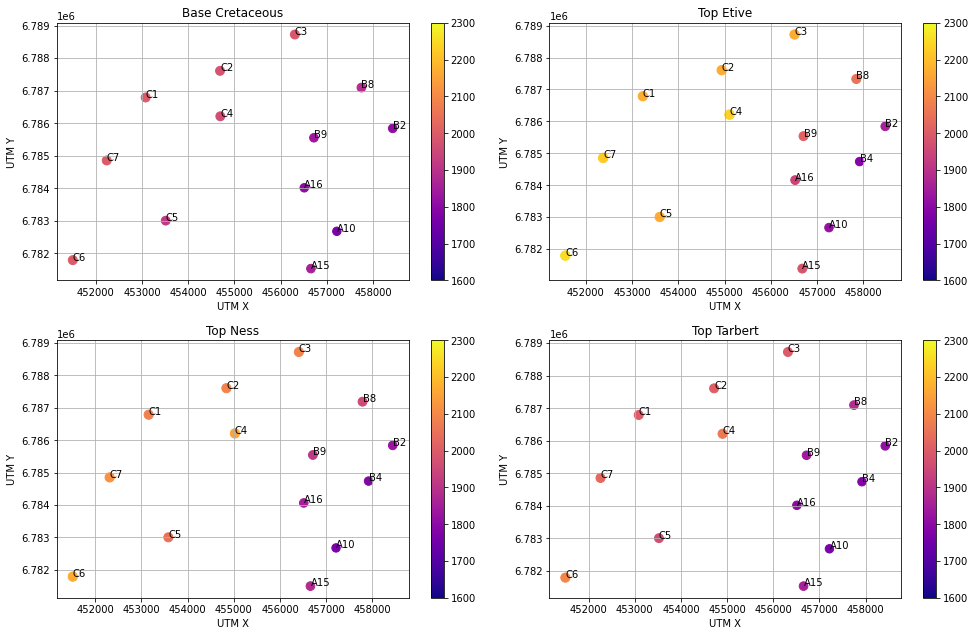

In [ ]:
topnames = ["Base Cretaceous", "Top Etive", "Top Ness", "Top Tarbert"]

plt.figure(figsize=(14,9))

for i in range(len(topnames)):
  df_ = welltop[welltop["Top Name"]==topnames[i]]
  x, y, z = df_["UTM X"].values, df_["UTM Y"].values, df_["TVD"].values

  plt.subplot(2,2,i+1)
  plt.scatter(x, y, c=z, s=z/25, cmap="plasma")
  
  # Annotate with well names
  wellname = df_["Well Name"].values
  for j, txt in enumerate(wellname):
      plt.annotate(txt, (x[j], y[j]))  

  plt.colorbar()
  plt.clim(1600,2300)
  plt.title(topnames[i])
  plt.xlabel("UTM X"); plt.ylabel("UTM Y")
  plt.grid()

plt.tight_layout(1.3)
plt.show()

## Add spatial coordinate to dataframe

## 3D kriging

In [ ]:
!pip install pykrige

     |████████████████████████████████| 993kB 5.1MB/s 


In [ ]:
df_new

,depth,poro,perm,well,tvd,perm_averaged
4,1501.6290,0.267428,124.57990,A10,1501.173566,NaN
5,1502.1290,0.256076,125.33458,A10,1501.543344,NaN
6,1502.6290,0.242126,117.12110,A10,1501.913075,NaN
7,1503.1290,0.238589,109.64679,A10,1502.282761,NaN
8,1503.6290,0.238377,106.01107,A10,1502.652403,NaN
...,...,...,...,...,...,...
20191,2570.5419,0.134343,404.45474,C7,2377.053250,244.317248
20192,2571.0419,0.130360,351.35257,C7,2377.261790,248.876365
20193,2571.5419,0.157732,331.12872,C7,2377.470331,250.314507
20194,2572.0419,0.146786,287.46310,C7,2377.678871,248.347761
